In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [3]:
# определеяем папки, в которых лежат данные
train_folder = 'C:/Users/egoro/ml_project/train/'
val_folder = 'C:/Users/egoro/ml_project/val/' # если есть набор валидационный
test_folder = 'C:/Users/egoro/ml_project/test/'
# разделяем датасеты здоровые/больные
os.listdir(train_folder)
# папка для Здоровых
train_normal = train_folder + 'NORMAL/'
# папка для Заболевших
train_pnumonia = train_folder + 'PNEUMONIA/'
# выводим количество снимков
print("Количество снимков здоровых людей: {}".format(len(os.listdir(train_normal))))
print("Количество снимков здоровых людей: {}".format(len(os.listdir(train_pnumonia))))

Количество снимков здоровых людей: 1349
Количество снимков здоровых людей: 1500


Название случайно выбранного здорового снимка:  NORMAL2-IM-1234-0001.jpeg
Название случайно выбранного снимка Пневмонии:  person5_bacteria_19.jpeg


Text(0.5, 1.0, 'Пневмония')

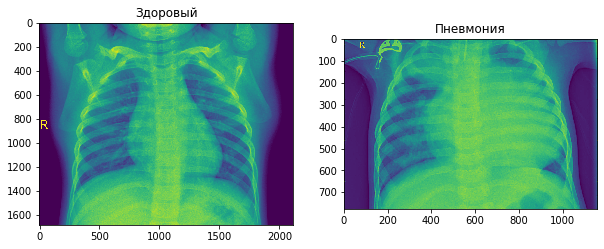

In [4]:
# возьмем случайно фото с папки здоровых снимков
rand_norm = np.random.randint(0,len(os.listdir(train_normal)))
norm_pic = os.listdir(train_normal)[rand_norm]
print('Название случайно выбранного здорового снимка: ',norm_pic)
norm_pic_address = train_normal + norm_pic
# возьмем снимок заболевшего Пневмонией
rand_p = np.random.randint(0,len(os.listdir(train_pnumonia)))
pnevm_pic =  os.listdir(train_pnumonia)[rand_norm]
pnevm_sic_address = train_pnumonia + pnevm_pic
print('Название случайно выбранного снимка Пневмонии: ', pnevm_pic)

# загружаем изображение
norm_load = Image.open(norm_pic_address) # снимок здорового
pnevm_load = Image.open(pnevm_sic_address) # снимок заболевшего

# выводим
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Здоровый')
a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pnevm_load)
a2.set_title('Пневмония')

In [5]:
import cv2

def preprocessing_image(path):
    """Функция для преобразования фотографий."""
    
    # создаем пустой список для записи датасета
    X = []
    y = []
    # получаем все файлы из папки с здоровыми снимками
    for fileName in os.listdir(path + "NORMAL"):
        # открываем изображение
        img = cv2.imread(path + "NORMAL/" + fileName)
        if img is not None:
            y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    # получаем все файлы из папки с пневмонией
    for fileName in os.listdir(path + "PNEUMONIA"): 
        img = cv2.imread(path + "PNEUMONIA/" + fileName)
        if img is not None:
            y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)
    return X, y

In [6]:
# датасет для обучения
X_train, y_train = preprocessing_image(train_folder)
# датасет для тестирования
X_test, y_test = preprocessing_image(test_folder)
# датасет для валидации
X_valid, y_valid = preprocessing_image(val_folder)

In [7]:
# Нормализуем изображения, чтобы градиенты не расходились
X_train = np.array(X_train)/255 # обучающий
X_test = np.array(X_test)/255 # тестовый
X_valid = np.array(X_valid)/255 # валидации

# Устанавливем мат.ожидание на 0 и дисперсию на 1
X_train = (X_train - np.average(X_train,0))/np.std(X_train,0) # обучающий
X_test = (X_test - np.average(X_test,0))/np.std(X_test,0) # тестовый
X_valid = (X_valid - np.average(X_valid,0))/np.std(X_valid,0) # валидации
# конвертируем значения метки           
y_train = np.array(y_train) # обучающий
y_test = np.array(y_test) # тестовый
y_valid = np.array(y_valid) # валидации
#  np.array(y_valid)

In [8]:
print("Размер обучающего датасета: ", X_train.shape)
print("Размер обучающего датасета: ", X_test.shape)
print("Размер обучающего датасета: ", X_valid.shape)

Размер обучающего датасета:  (2849, 64, 64, 3)
Размер обучающего датасета:  (624, 64, 64, 3)
Размер обучающего датасета:  (16, 64, 64, 3)


In [16]:
def batch_generator(X, y, batch_size=64, shuffle=False, random_seed=None):
    """Функция для проходу по мини-пакетам данных."""
    
    idx = np.arange(y.shape[0])
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [17]:
import tensorflow as tf
import numpy as np

# функция для сверточного слоя
def conv_layer(input_tensor, name, kernel_size, n_output_channels,
              padding_mode = 'SAME', strides=(1, 1, 1, 1)):
    """Функция для сверточного слоя."""
    
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list() # получаем размер входа и переводим его в list
        n_input_channels = input_shape[-1] # определяем количество входных каналов
        weights_shape = list(kernel_size) + [n_input_channels,n_output_channels] # определяем матрицу ядра
        weights = tf.get_variable(name = '_weights', shape = weights_shape) # матрица ядра
        print("Значение для весов: ", weights)
        biases = tf.get_variable(name='_biases', initializer = tf.zeros(shape=[n_output_channels])) # смещение
        print("Значение для смещения: ", biases)
        conv = tf.nn.conv2d(input = input_tensor,
                           filter = weights,
                           strides = strides,
                           padding = padding_mode) # слоя свертки
        print("Значение слоя свертки", conv)
        conv = tf.nn.bias_add(conv, biases, name='net_pre_activation') # смещение
        print("Значение слоя свертки с смещением", conv)
        conv = tf.nn.relu(conv, name='activation') # активационная функция для передачи нейронов вперед
        print("Активация сверточного слоя: ", conv)
        return conv

In [18]:
def fc_layer(input_tensor, name, n_output_units, activation_fn=None):
    """Функция для полносвязного слоя."""
    
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:] # первый элемент смещение
        n_input_units = np.prod(input_shape) # произведение элементов массива
        # проверяем вход, если его размер меньше 1, то преобразуем в тензор
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, shape=(-1, n_input_units)) # получим тензор
        wieghts_shape = [n_input_units, n_output_units]
        weights = tf.get_variable(name='_weights', shape = wieghts_shape)
        print("Значение для весов: ", weights)
        biases = tf.get_variable(name='_biases', initializer=tf.zeros(shape=[n_output_units])) # смещение
        print("Значение для смещения: ", biases)
        layer = tf.matmul(input_tensor, weights) # произведение тензора на вес
        print("Значение для общего входа: ", layer)
        layer = tf.nn.bias_add(layer, biases, name='net_pre-activation') # добавление смещения к слою
        print("Значение для общего входа с добавлением смещения: ", layer)
        if activation_fn is None:
            return layer
        layer = activation_fn(layer,name='activation') # функция активации
        print("Значение для активации слоя: ", layer)
        return layer, weights

In [19]:
def build_cnn(lambd, regularization):
    """Строим архитектуру CNN."""
    
    # заполняем значения для тензора признаков
    tf_x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3], name='tf_x')
    # заполняем значения
    tf_y = tf.placeholder(tf.int32, shape=[None], name='tf_y')
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=2, dtype=tf.float32, name='tf_y_onehot')
    print("Инициализация 1 слоя - сверточный слоя + max pooling")
    # первый слой - сверточный слой 1
    h1 = conv_layer(tf_x, name = 'conv_1', kernel_size=(3, 3), padding_mode = 'VALID',
                   n_output_channels=32)
    # объединение по максимуму
    h1_pool = tf.nn.max_pool(h1, ksize=[1,1,1,1], strides=[1,1,1,1],padding='SAME')
    print("Инициализация 2 слоя - сверточный слоя + max pooling")
    # второй слой
    h2 = conv_layer(h1_pool, name = 'conv_2', kernel_size=(3, 3), padding_mode = 'VALID',
                   n_output_channels=64)
    # объединение по максимуму
    h2_pool = tf.nn.max_pool(h2, ksize=[1,1,1,1], strides=[1,1,1,1],padding='SAME')
    print("Инициализация 3 слоя - полносвязный слой + отключение нейронов для формирования нескольких моделей")
    # третий слой полносвязный слой
    h3, h3_weights = fc_layer(h2_pool, name = 'fc_3', n_output_units=1024,
                 activation_fn = tf.nn.relu)
    # отключение
    keep_prob = tf.placeholder(tf.float32, name = 'fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob=keep_prob, name='dropout_layer')
    
    # четвертый слой - полносвязный (линейная активация)
    print('Инициализация 4 слоя - полносвязный слоя для формирования ответов принадлежности к классу')
    h4 = fc_layer(h3_drop, name = 'fc_4', n_output_units=2,
                 activation_fn = None)
    # прогнозирование
    # для бинарной классификации можно брать слой tf.nn.softmax, но на нам не требуется нормирование вероятности,
    # чтобы сформировать ответ
    predictions={'probabilities': tf.nn.sigmoid(h4, name ='probabilities'),
                'labels': tf.cast(tf.argmax(h4, axis=1), tf.int32, name='labels')}
    # определение потерь во время обучения
    # при использовании tf.nn.softmax в формировании ответов, для вычисления потерь
    # необходимо использовать tf.nn.softmax_cross_entropy_with_logits
    cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=h4,
                                                                               labels=tf_y_onehot),
                                       name='cross_entropy_loss')
    # добавление L1 регуляризации для формирования разреженных векторов признаков
    if regularization == 'L1':
        L1_norm = tf.norm(h3_weights, ord='fro', axis=(0,1))
        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss+lambd*L1_norm,
                                    name='train_op')
    # добавление L2 регуляризации для сокращения сложности модели за счет штрафования крупных весов
    elif regularization == 'L2':
        L2_norm = tf.norm(h3_weights, ord='euclidean', axis=(0,1))
        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss+lambd*L2_norm,
                                    name='train_op')
    # добавление L1 и L2
    elif regularization == ['L1', 'L2']:
        L1_norm = tf.norm(h3_weights, ord='fro', axis=(0,1))
        L2_norm = tf.norm(h3_weights, ord='euclidean', axis=(0,1))
        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss+lambd*L1_norm+lambd*L2_norm,
                                    name='train_op')
    elif regularization == None:
        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss, name = 'train_op')
    # вычисление корректных прогнозов и доли правильных ответов
    correct_predictions = tf.equal(predictions['labels'], tf_y, name = 'correct_predictions')
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name ='accuracy')

In [20]:
def save(saver, sess, epoch, path='./model2/'):
    """Сохранение модели."""
    
    # определяем, есть ли папка, если нет, создаем
    if not os.path.isdir(path):
        os.makedirs(path)
    print("Сохранение модели в %s"% path)
    saver.save(sess, os.path.join(path, 'cnn-model.ckpt'),
              global_step=epoch)
    
def load(saver, sess, path):
    """Загрузка модели."""
    
    print('Загрузка модели из %s'%path)
    saver.restore(sess, tf.train.latest_checkpoint(path))
    
def fit(sess, training_set, validation_set=None,
         initialize=True, epochs=20, shuffle=True,
         dropout = 0.5, random_seed=None):
    """Обучение модели."""
    
    # определяем входные данные
    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss=[]
    # инициализация переменных
    if initialize:
        sess.run(tf.global_variables_initializer())
    np.random.seed(random_seed) # для тасования набора
    # цикл по эпохам
    for epoch in range(1, epochs+1):
        # генерация батчей для обучения
        batch_gen = batch_generator(X_data, y_data, shuffle=shuffle)
        avg_loss=0.0
        # цикл по итерациям (батчами)
        for i, (batch_x, batch_y) in enumerate(batch_gen):
            # словарь для входа нейронки
            feed = {'tf_x:0':batch_x,
                   'tf_y:0':batch_y,
                   'fc_keep_prob:0':dropout}
            # определение значения потерь
            loss, _ = sess.run(
                    ['cross_entropy_loss:0', 'train_op'],
                    feed_dict=feed)
            avg_loss += loss
            
        training_loss.append(avg_loss)
        print('Эпоха %02d. Средние потери при обучении: %7.3f'%(epoch,avg_loss), end=' ')
        if validation_set is not None:
            feed = {'tf_x:0':validation_set[0],
                   'tf_y:0':validation_set[1],
                   'fc_keep_prob:0':1.0}
            valid_acc=sess.run('accuracy:0', feed_dict = feed)
            print('Правильность при проверке: %7.4f'%valid_acc)
        else:
            print()
def predict(sess, X_test, return_proba=False):
    """Функция для формирования прогноза."""
    
    feed = {'tf_x:0':X_test,
           'fc_keep_prob:0':1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict = feed)
    else:
        return sess.run('labels:0',feed_dict=feed)
    

In [21]:
# определение гиперпараметров

# Регуляризация
#regularization = ['L1', 'L2']
regularization = None
#regularization = 'L1'

# Cила регуляризаци
lambd = None
#lambd = 0.5

# Скорость обучения
learning_rate=1e-4
# learning_rate=1e-3
# learning_rate=1e-2

# формирования случайных значений для тасования набора
random_seed=123

# инициализация графа вычислений
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    build_cnn(lambd, regularization)
    saver = tf.train.Saver()

Инициализация 1 слоя - сверточный слоя + max pooling
Значение для весов:  <tf.Variable 'conv_1/_weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>
Значение для смещения:  <tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Значение слоя свертки Tensor("conv_1/Conv2D:0", shape=(?, 62, 62, 32), dtype=float32)
Значение слоя свертки с смещением Tensor("conv_1/net_pre_activation:0", shape=(?, 62, 62, 32), dtype=float32)
Активация сверточного слоя:  Tensor("conv_1/activation:0", shape=(?, 62, 62, 32), dtype=float32)
Инициализация 2 слоя - сверточный слоя + max pooling
Значение для весов:  <tf.Variable 'conv_2/_weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>
Значение для смещения:  <tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Значение слоя свертки Tensor("conv_2/Conv2D:0", shape=(?, 60, 60, 64), dtype=float32)
Значение слоя свертки с смещением Tensor("conv_2/net_pre_activation:0", shape=(?, 60, 60, 64), dtype=float32)
Активация сверточного слоя:  Tensor("conv_2/

In [22]:
# ЕСЛИ ХОТИМ ПОСМОТРЕТЬ РЕЗУЛЬТАТЫ МОДЕЛИ, ПРОПУСКАЕМ ЭТУ ЯЧЕЙКУ

# запуск процесса обучения
with tf.Session(graph=g) as sess:
    # обучение
    fit(sess, training_set = (X_train, y_train),
              validation_set=None,
              initialize=True, random_seed=123)
    # сохранение модели по окончанию обучения
    save(saver, sess, epoch=20)

Эпоха 01. Средние потери при обучении:  15.289 
Эпоха 02. Средние потери при обучении:   3.868 
Эпоха 03. Средние потери при обучении:   2.570 
Эпоха 04. Средние потери при обучении:   1.659 
Эпоха 05. Средние потери при обучении:   0.966 
Эпоха 06. Средние потери при обучении:   0.726 
Эпоха 07. Средние потери при обучении:   0.337 
Эпоха 08. Средние потери при обучении:   0.173 
Эпоха 09. Средние потери при обучении:   0.171 
Эпоха 10. Средние потери при обучении:   0.117 
Эпоха 11. Средние потери при обучении:   0.090 
Эпоха 12. Средние потери при обучении:   0.066 
Эпоха 13. Средние потери при обучении:   0.070 
Эпоха 14. Средние потери при обучении:   0.042 
Эпоха 15. Средние потери при обучении:   0.035 
Эпоха 16. Средние потери при обучении:   0.041 
Эпоха 17. Средние потери при обучении:   0.030 
Эпоха 18. Средние потери при обучении:   0.021 
Эпоха 19. Средние потери при обучении:   0.020 
Эпоха 20. Средние потери при обучении:   0.018 
Сохранение модели в ./model2/


In [23]:
# Загрузка сохраненной модели

# удаляем сессию обучения, чтобы не забивать память
del g
# создание нового графа и построение модели
g2 = tf.Graph()
regularization = None
# Cила регуляризаци
lambd = None
# Скорость обучения
learning_rate=1e-4
random_seed=123
with g2.as_default():
    tf.set_random_seed(random_seed)
    build_cnn(lambd, regularization)
    saver = tf.train.Saver()
# создание нового сеанса
# загружаем файл для прогноза
with tf.Session(graph=g2) as sess:
    load(saver, sess, path='C:/Users/egoro/ml_project/model2/')
    pred_test = predict(sess, X_test, return_proba=False)
    print('Точность на тестовом наборе: {}'.format(100*np.sum(pred_test==y_test)/len(y_test)))
    pred_train = predict(sess, X_train, return_proba=False)
    print('Точность на обучающем наборе: {}'.format(100*np.sum(pred_train==y_train)/len(y_train)))

Инициализация 1 слоя - сверточный слоя + max pooling
Значение для весов:  <tf.Variable 'conv_1/_weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>
Значение для смещения:  <tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Значение слоя свертки Tensor("conv_1/Conv2D:0", shape=(?, 62, 62, 32), dtype=float32)
Значение слоя свертки с смещением Tensor("conv_1/net_pre_activation:0", shape=(?, 62, 62, 32), dtype=float32)
Активация сверточного слоя:  Tensor("conv_1/activation:0", shape=(?, 62, 62, 32), dtype=float32)
Инициализация 2 слоя - сверточный слоя + max pooling
Значение для весов:  <tf.Variable 'conv_2/_weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>
Значение для смещения:  <tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Значение слоя свертки Tensor("conv_2/Conv2D:0", shape=(?, 60, 60, 64), dtype=float32)
Значение слоя свертки с смещением Tensor("conv_2/net_pre_activation:0", shape=(?, 60, 60, 64), dtype=float32)
Активация сверточного слоя:  Tensor("conv_2/

Инициализация 1 слоя - сверточный слоя + max pooling
Значение для весов:  <tf.Variable 'conv_1/_weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>
Значение для смещения:  <tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Значение слоя свертки Tensor("conv_1/Conv2D:0", shape=(?, 62, 62, 32), dtype=float32)
Значение слоя свертки с смещением Tensor("conv_1/net_pre_activation:0", shape=(?, 62, 62, 32), dtype=float32)
Активация сверточного слоя:  Tensor("conv_1/activation:0", shape=(?, 62, 62, 32), dtype=float32)
Инициализация 2 слоя - сверточный слоя + max pooling
Значение для весов:  <tf.Variable 'conv_2/_weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>
Значение для смещения:  <tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Значение слоя свертки Tensor("conv_2/Conv2D:0", shape=(?, 60, 60, 64), dtype=float32)
Значение слоя свертки с смещением Tensor("conv_2/net_pre_activation:0", shape=(?, 60, 60, 64), dtype=float32)
Активация сверточного слоя:  Tensor("conv_2/

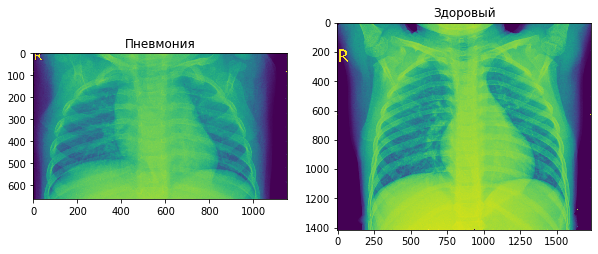

In [32]:
# Загрузка сохраненной модели

# удаляем сессию обучения, чтобы не забивать память
del g2
# создание нового графа и построение модели
regularization = None
# Cила регуляризаци
lambd = None

# Скорость обучения
learning_rate=1e-4

# формирования случайных значений для тасования набора
random_seed=123

# инициализация графа вычислений
g2 = tf.Graph()
with g2.as_default():
    tf.set_random_seed(random_seed)
    build_cnn(lambd, regularization)
    saver = tf.train.Saver()
# создание нового сеанса
# загружаем файл для прогноза
path = 'C:/Users/egoro/ml_project/val/PNEUMONIA/' # папка, где находится файл
fileName = 'person1947_bacteria_4876.jpeg' # название файла
path1 = 'C:/Users/egoro/ml_project/val/NORMAL/' # папка, где находится файл
fileName1 = 'NORMAL2-IM-1431-0001.jpeg' # название файла
with tf.Session(graph=g2) as sess:
    # загрузка модели
    load(saver, sess, path='C:/Users/egoro/ml_project/model2/')
    # загрузка изображения
    X_prognoz = cv2.imread(path + fileName)
    X_prognoz1 = cv2.imread(path1 + fileName1)
    # преобразование изображение в размерность (64, 64)
    X_prognoz = cv2.resize(X_prognoz,(64,64))
    X_prognoz1 = cv2.resize(X_prognoz1,(64,64))
    # преобразование данных в массив
    X_prognoz = np.array(X_prognoz)/255
    X_prognoz1 = np.array(X_prognoz1)/255
    # преобразование в тензор для формирования ответа
    X_prognoz = X_prognoz.reshape(1, 64,64,3)
    X_prognoz1 = X_prognoz1.reshape(1, 64,64,3)
    # получение прогноза
    pred_ = predict(sess, X_prognoz, return_proba=False)
    print(pred_)
    if int(pred_[0]) == 0:
        prognoz_metka = 'Здоровый'
    elif int(pred_[0]) == 1:
        prognoz_metka = 'Пневмония'
    pred_1 = predict(sess, X_prognoz1, return_proba=False)
    print(pred_1)
    if int(pred_1[0]) == 0:
        prognoz_metka1 = 'Здоровый'
    elif int(pred_1[0]) == 1:
        prognoz_metka1 = 'Пневмония'
    pic_load = Image.open(path + fileName)
    pic_load1 = Image.open(path1 + fileName1)
    # выводим
    f = plt.figure(figsize = (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(pic_load)
    a1.set_title(prognoz_metka)
    a2 = f.add_subplot(1, 2, 2)
    img_plot = plt.imshow(pic_load1)
    a2.set_title(prognoz_metka1)